In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
from scipy import signal

import IPython.display
import cmocean as cm
import sys, os, glob
import warnings
warnings.simplefilter("ignore") 

from IPython.display import Image

from dask.distributed import Client

from matplotlib.patches import Rectangle

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rcParams['font.size'] = 15
letlab = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)',
          '(i)','(j)','(k)','(l)','(m)','(n)','(o)','(p)',
          '(q)','(r)','(s)','(t)','(u)','(v)','(w)','(x)','(y)','(z)']

In [3]:
# Load workers:
client = Client(n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46455/status,
Dashboard: /proxy/46455/status,Workers: 28
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36535,Workers: 28
Dashboard: /proxy/46455/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:33333,Total threads: 1
Dashboard: /proxy/35437/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:37919,


## Load datasets

In [4]:
base = '/g/data/e14/rmh561/croco/'
base_data = base + 'archive/'
base_analysis = base + '/analysis/'

os.chdir(base_analysis + 'PAC12_75_cpl')
sys.path.append(base_analysis + 'PAC12_75_cpl/Processing_Scripts')
sys.path.append(base_analysis + 'PAC12_75_cpl/Processing_Scripts/Tracer_balance_code_LMaillard_v2')

In [5]:
# Load custom scripts/tools:
import pac12_tools as ptools
import R_tools_fort as ftools
filt_width = 6.

In [6]:
# define runs:
expdict = {
           'CROCO-WRF Control':{'exp':'PAC12_75_cpl','expn':'exp02','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF PP81':{'exp':'PAC12_75_cpl','expn':'exp05','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO Control':{'exp':'PAC12_75','expn':'exp11','CPL':False,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO PP81':{'exp':'PAC12_75','expn':'exp12','CPL':False,'TSoffset': 2014.,'TIWoutput':False}
          }
cont = 'CROCO-WRF Control'

In [ ]:
# Load CROCO data:
data_typs = ['mon','day','mon_hp','mon_TIWhp','mon_TIWhpstd']#'3day','day','ts_3day']
dropvars = {'mon':['omega','u_sq','v_sq','salt_sq','AKv'],
            'day':[],
            '3day':[],
            'ts_3day':[],
            'mon_hp':[],
            'mon_TIWhp':[],
            'mon_TIWhpstd':[]}
dropyears = ['2014']
#dropyears = ['2015','2016','2017','2018']
S1 = 39

data = {}
for nam in expdict.keys():
    print(nam)
    exp = expdict[nam]['exp']
    expn = expdict[nam]['expn']
    data[nam] = {}
    for typ in data_typs:
        try:
            files = sorted(glob.glob(base_data + exp + '/' + exp + '_' + expn + '/*/croco_out_' + typ + '.nc'))
            for yr in dropyears:
                files = [file for file in files if yr not in file]
            data[nam][typ] = xr.open_mfdataset(files, concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',drop_variables=dropvars[typ],parallel=True,chunks={'time_counter':1}).rename({'time_counter':'time'})
            
            # Do coordinates:
            if 'TIW' in typ:
                data[nam][typ] = ptools.create_coords_CROCO_TIW(data[nam][typ],grd)
            else:
                data[nam][typ] = ptools.create_coords_CROCO(data[nam][typ])
        except:
            data[nam][typ] = None
gfiles = glob.glob(base_data + exp + '/' + exp + '_' + expn + '/*/croco_out_grd.nc')
grd = xr.open_dataset(gfiles[0],chunks={'y_rho':100,'x_rho':100})

# Generate xgcm grid object:
nam = cont
grid = Grid(data[nam]['mon'],coords={"x":{"center":"x_rho","inner":"x_u"},
                         "y":{"center":"y_rho","inner":"y_v"},
                         "s":{"center":"s_rho","outer":"s_w"}},periodic=False)

In [19]:
# Set limit parameters for observations:
for nam in expdict.keys():
    try:
        minyr  = data[nam]['mon'].time.min('time').values.astype('datetime64[Y]').astype(int)+1970
        maxyr  = data[nam]['mon'].time.max('time').values.astype('datetime64[Y]').astype(int)+1970
        print(nam + ' minyr=' + str(minyr) + ' maxyr=' + str(maxyr))
    except:
        print('No data for ' + nam)
nam = 'CROCO-WRF Control'
minyr  = data[nam]['mon'].time.min('time').values.astype('datetime64[Y]').astype(int)+1970
maxyr  = data[nam]['mon'].time.max('time').values.astype('datetime64[Y]').astype(int)+1970
minlon = data[nam]['mon'].x_rho.min('x_rho').values
maxlon = data[nam]['mon'].x_rho.max('x_rho').values
minlat = data[nam]['mon'].y_rho.min('y_rho').values
maxlat = data[nam]['mon'].y_rho.max('y_rho').values

CROCO-WRF Control minyr=2015 maxyr=2018
CROCO-WRF PP81 minyr=2015 maxyr=2018
CROCO Control minyr=2015 maxyr=2018
CROCO PP81 minyr=2015 maxyr=2018


In [20]:
# SODA reanalysis:
files = []
for yr in np.arange(minyr,maxyr+1,1):
    files += sorted(glob.glob('/g/data/e14/rmh561/croco/data/DATA/SODA342_PAC12_75/soda3.4.2_5dy_ocean_reg_' + str(yr) + '_*.nc'))
SODA = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

SODA = SODA.sel(xt_ocean=slice(minlon,maxlon)).sel(yt_ocean=slice(minlat,maxlat)).sel(xu_ocean=slice(minlon,maxlon)).sel(yu_ocean=slice(minlat,maxlat))
SODA = SODA.rename({'xt_ocean':'x_rho','yt_ocean':'y_rho'})

## Annual Mean Surface Properties:

In [12]:
CROCO_SST = {}
CROCO_SSH = {}
CROCO_SFLX = {}
CROCO_HBL = {}
CROCO_USQ = {}
CROCO_VSQ = {}
for nam in expdict.keys():
    CROCO_SST[nam] = data[nam]['mon'].temp.isel(s_rho=-1).mean('time').load()
    CROCO_SSH[nam] = (data[nam]['mon'].zeta.mean('time') - data[nam]['mon'].zeta.mean('time').mean('x_rho').mean('y_rho')).load()
    CROCO_SFLX[nam] = data[nam]['mon'].shflx.mean('time').load()
    CROCO_HBL[nam] = data[nam]['mon'].hbl.mean('time').load()
    CROCO_USQ[nam] = (data[nam]['mon'].u_sq.isel(s_rho=-1).mean('time')-data[nam]['mon'].u.isel(s_rho=-1).mean('time')**2.).load()
    CROCO_VSQ[nam] = (data[nam]['mon'].v_sq.isel(s_rho=-1).mean('time')-data[nam]['mon'].v.isel(s_rho=-1).mean('time')**2.).load()

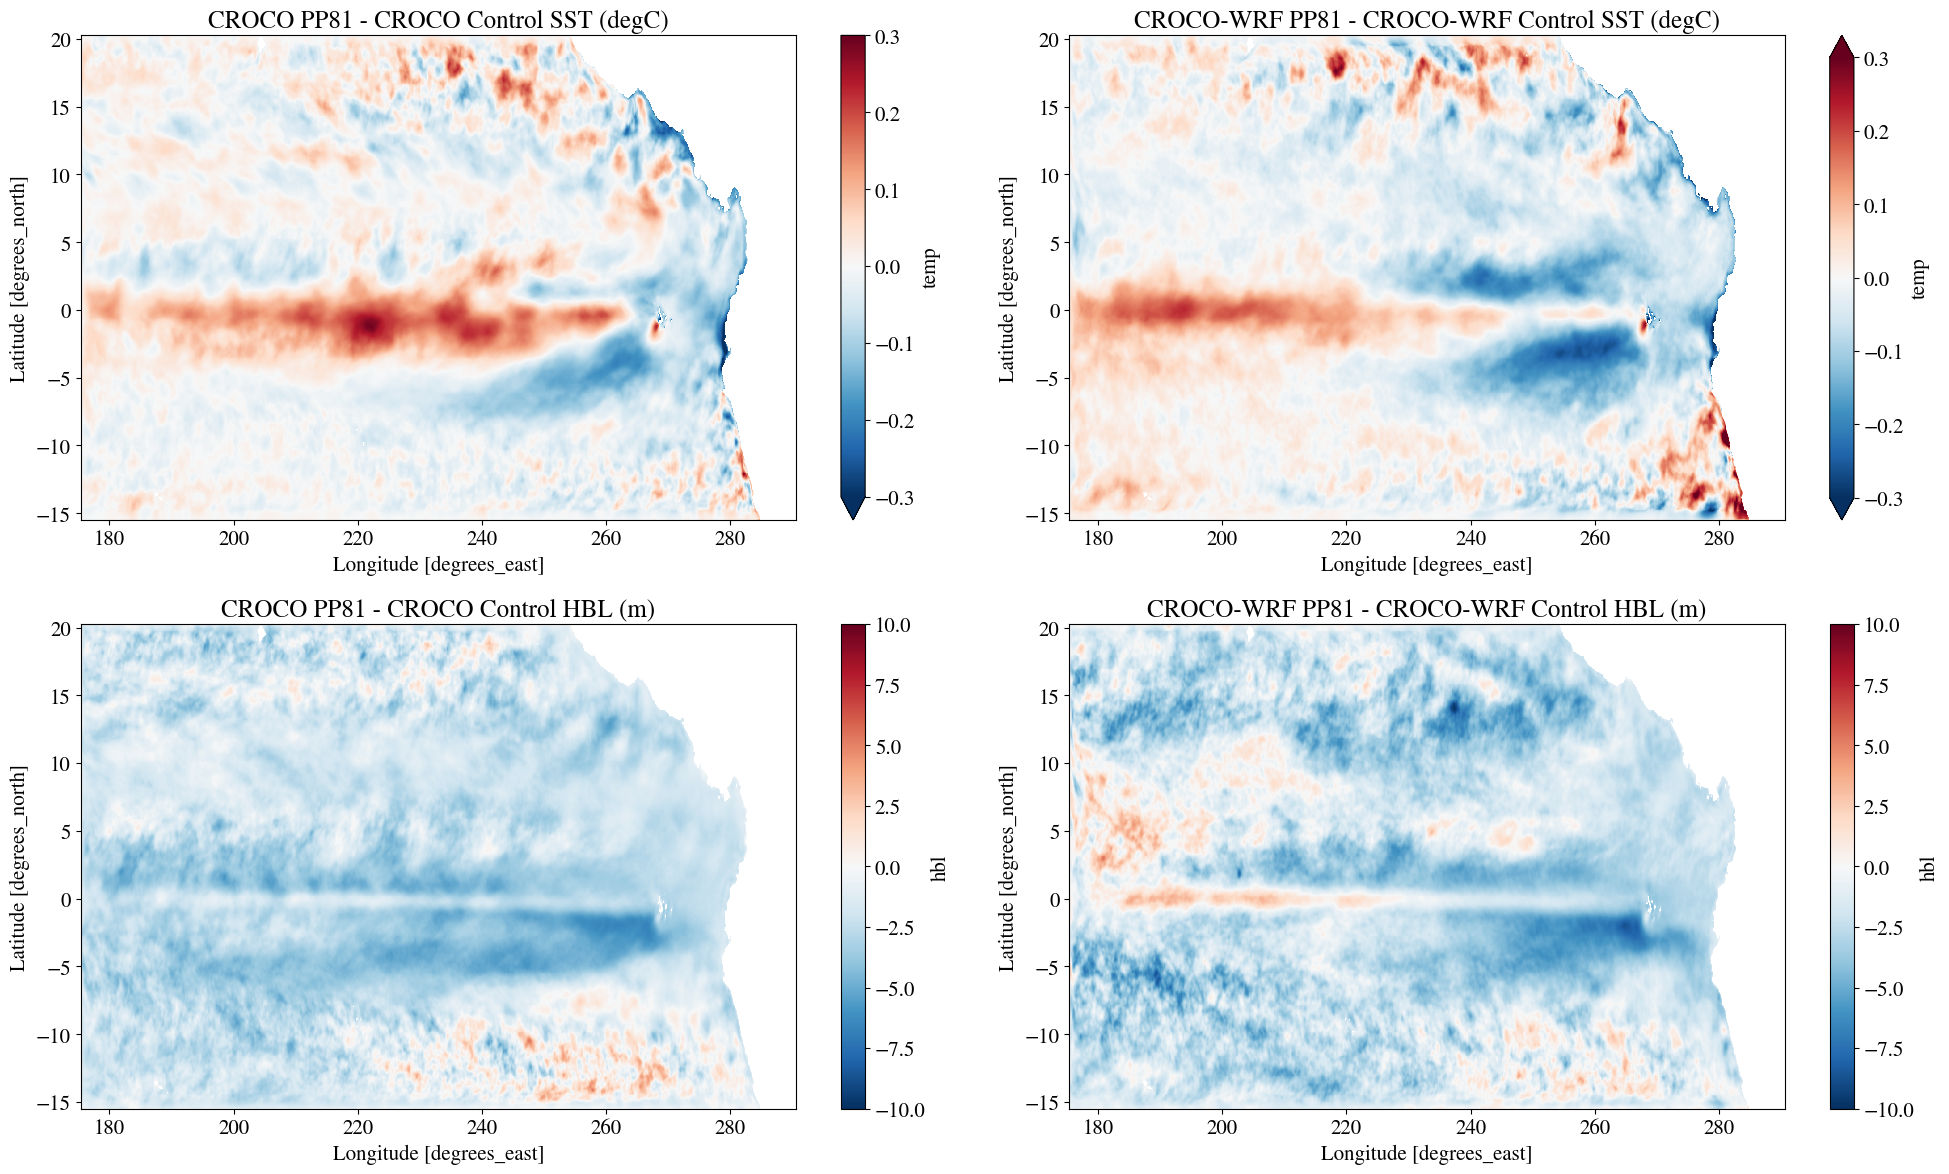

In [16]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,12),facecolor='w')

(CROCO_SST['CROCO PP81']-CROCO_SST['CROCO Control']).plot(ax=axes[0][0],vmin=-0.3,vmax=0.3,cmap='RdBu_r')
axes[0][0].set_title('CROCO PP81 - CROCO Control SST (degC)')

(CROCO_SST['CROCO-WRF PP81']-CROCO_SST['CROCO-WRF Control']).plot(ax=axes[0][1],vmin=-0.3,vmax=0.3,cmap='RdBu_r')
axes[0][1].set_title('CROCO-WRF PP81 - CROCO-WRF Control SST (degC)')

(CROCO_HBL['CROCO PP81']-CROCO_HBL['CROCO Control']).plot(ax=axes[1][0],vmin=-10,vmax=10,cmap='RdBu_r')
axes[1][0].set_title('CROCO PP81 - CROCO Control HBL (m)')

(CROCO_HBL['CROCO-WRF PP81']-CROCO_HBL['CROCO-WRF Control']).plot(ax=axes[1][1],vmin=-10,vmax=10,cmap='RdBu_r')
axes[1][1].set_title('CROCO-WRF PP81 - CROCO-WRF Control HBL (m)')

plt.tight_layout()

plt.savefig('Mixing_Comparisons/PP81_CROCO_CROCO-WRF_SST_HBL.png',dpi=100)

## Vertical profiles with observations

In [21]:
# TAO and Johnson data extraction function:
obs_th = 2500 # This criteria denotes the minimum number of observations at a given depth required to include this point in the comparison.
def get_TAO(lonTAO):
    # Load temperature:
    tao_file_temp = xr.open_dataset('/g/data/ik11/observations/TAO/test/t0n' + lonTAO + '_dy.cdf')
    tao_temp = tao_file_temp['T_20'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))
    tao_temp = tao_temp.where(tao_temp!=1.e35)
    count = np.count_nonzero(~np.isnan(tao_temp), axis=0)
    tao_temp = tao_temp.isel(depth=count>=obs_th) # Only average if more than x observations at given depth
    
    # Load zonal velocity from ADCP data:
    tao_file_u = xr.open_dataset('/g/data/ik11/observations/TAO/test/adcp0n' + lonTAO + '_dy.cdf')
    tao_u = tao_file_u['u_1205'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))/100.
    tao_u = tao_u.where(abs(tao_u)<=100.)
    count = np.count_nonzero(~np.isnan(tao_u), axis=0)
    tao_u = tao_u.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth

    # Load zonal velocity from current data:
    tao_file_uc = xr.open_dataset('/g/data/ik11/observations/TAO/cur0n' + lonTAO + '_dy.cdf')
    tao_uc = tao_file_uc['U_320'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))/100.
    tao_uc = tao_uc.where(abs(tao_uc)<=100.)
    count = np.count_nonzero(~np.isnan(tao_uc), axis=0)
    tao_uc = tao_uc.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth
    
    return tao_temp, tao_u, tao_uc

# Johnson data function:
def get_Joh(lonJoh):
    joh_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')
    joh_temp = joh_file['POTEMPM']
    joh_u = joh_file['UM']

    joh_temp_eq = joh_temp.sel(ZDEP1_50=slice(0,400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh,method='nearest')
    joh_u_eq = joh_u.sel(ZDEP1_50=slice(0,400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh,method='nearest')
    dep_joh = joh_temp_eq.ZDEP1_50
    
    return joh_temp_eq, joh_u_eq, dep_joh

In [22]:
TAO_T, TAO_U, TAO_UC = get_TAO('140w')
TAO_T = TAO_T.sel(time=slice('2015-01-01','2018-12-31'))
TAO_U = TAO_U.sel(time=slice('2015-01-01','2018-12-31'))

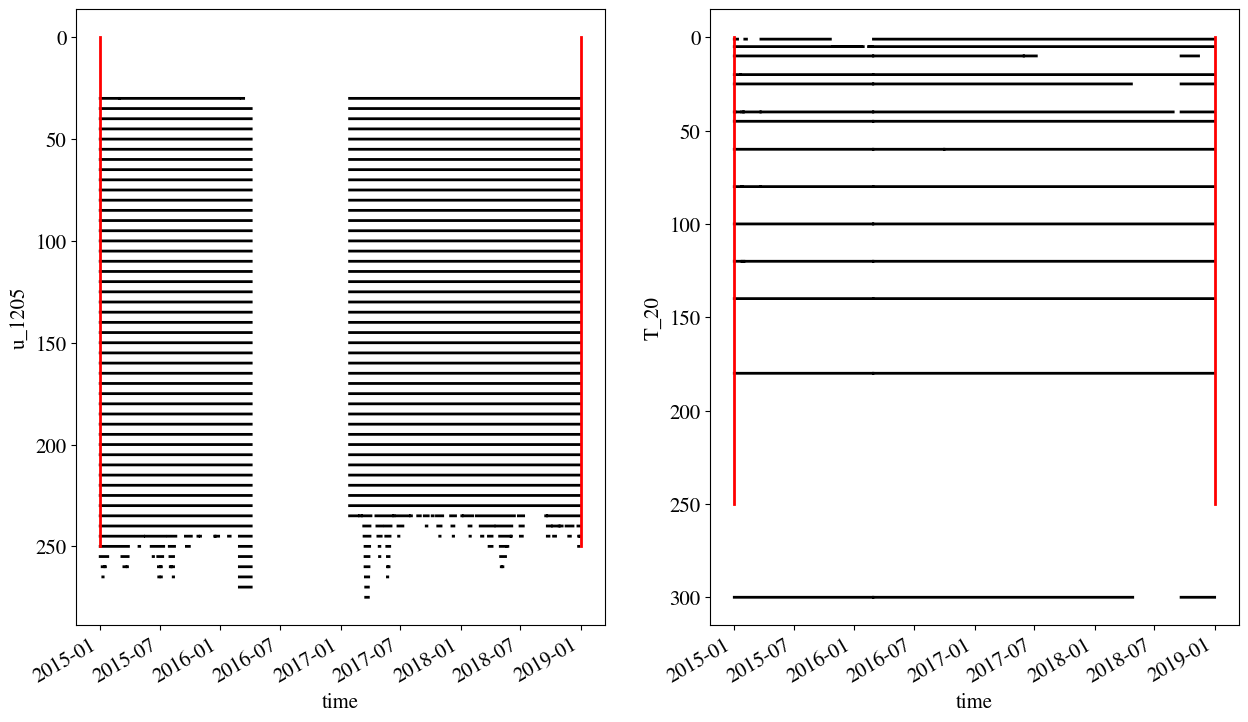

In [23]:
# TAO Data availability:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,8),facecolor='w')

UdL = len(TAO_U.depth)
TdL = len(TAO_T.depth)

for i in range(UdL):
    u = TAO_U.isel(depth=i)*0
    (u+TAO_U.depth.isel(depth=i).values).plot(ax=axes[0],color='k')
for i in range(TdL):
    t = TAO_T.isel(depth=i)*0
    (t+TAO_T.depth.isel(depth=i).values).plot(ax=axes[1],color='k')

    
dates = ['2015-01-01','2018-12-31']
times = TAO_U.time.sel(time=slice(dates[0],dates[1]))

for ax in axes:
    ax.set_title('')
    ax.invert_yaxis()
    
    ax.plot([times.isel(time=0).values,times.isel(time=0).values],[0.,250.],'-r')
    ax.plot([times.isel(time=-1).values,times.isel(time=-1).values],[0.,250.],'-r')

In [24]:
(u+TAO_U.depth.isel(depth=i)).sel(time='2016-04-04',method='nearest')
(u+TAO_U.depth.isel(depth=i)).sel(time='2017-01-28',method='nearest')

<xarray.DataArray ()>
array(nan, dtype=float32)
Coordinates:
    time     datetime64[ns] 2017-01-28T12:00:00
    lat      float32 0.0
    lon      float32 220.0

In [25]:
# Define time periods to do comparison on:
Ttimes = slice('2015-01-01','2018-12-31')
Utimes = [slice('2015-01-01','2016-04-04'),slice('2017-01-28','2018-12-31')]

In [26]:
# Calculations:
LON = 220.
lonTAO = '140w'
LAT = 0.
depths = (0.,300.)

# Model data processing:
UZ = {}
TZ = {}
for key in expdict.keys():
    print(key)
    tmp = data[key]['mon'].u.sel(x_u=LON,method='nearest').sel(y_u=LAT,method='nearest')
    UZ[key] = xr.concat([tmp.sel(time=Utimes[0]),tmp.sel(time=Utimes[1])],dim='time').mean('time').load()
    TZ[key] = data[key]['mon'].temp.sel(x_rho=LON,method='nearest').sel(y_rho=LAT,method='nearest').sel(time=Ttimes).mean('time').load()
    
Z = data['CROCO-WRF Control']['mon'].z_rho.sel(x_rho=LON,method='nearest').sel(y_rho=LAT,method='nearest').load()

# SODA data processing:
tmp = SODA.u.sel(xu_ocean=LON,method='nearest').sel(yu_ocean=LAT,method='nearest')
SODA_UZ = xr.concat([tmp.sel(time=Utimes[0]),tmp.sel(time=Utimes[1])],dim='time').mean('time').load()
SODA_TZ = SODA.temp.sel(x_rho=LON,method='nearest').sel(y_rho=LAT,method='nearest').sel(time=Ttimes).mean('time').load()
SODA_Z = -SODA.st_ocean

# TAO data processing:
TAO_T_TAOm = TAO_T.sel(time=Ttimes).mean('time').load()
TAO_U_TAOm = xr.concat([TAO_U.sel(time=Utimes[0]),TAO_U.sel(time=Utimes[1])],dim='time').mean('time').load()

CROCO-WRF Control
CROCO-WRF PP81
CROCO Control
CROCO PP81


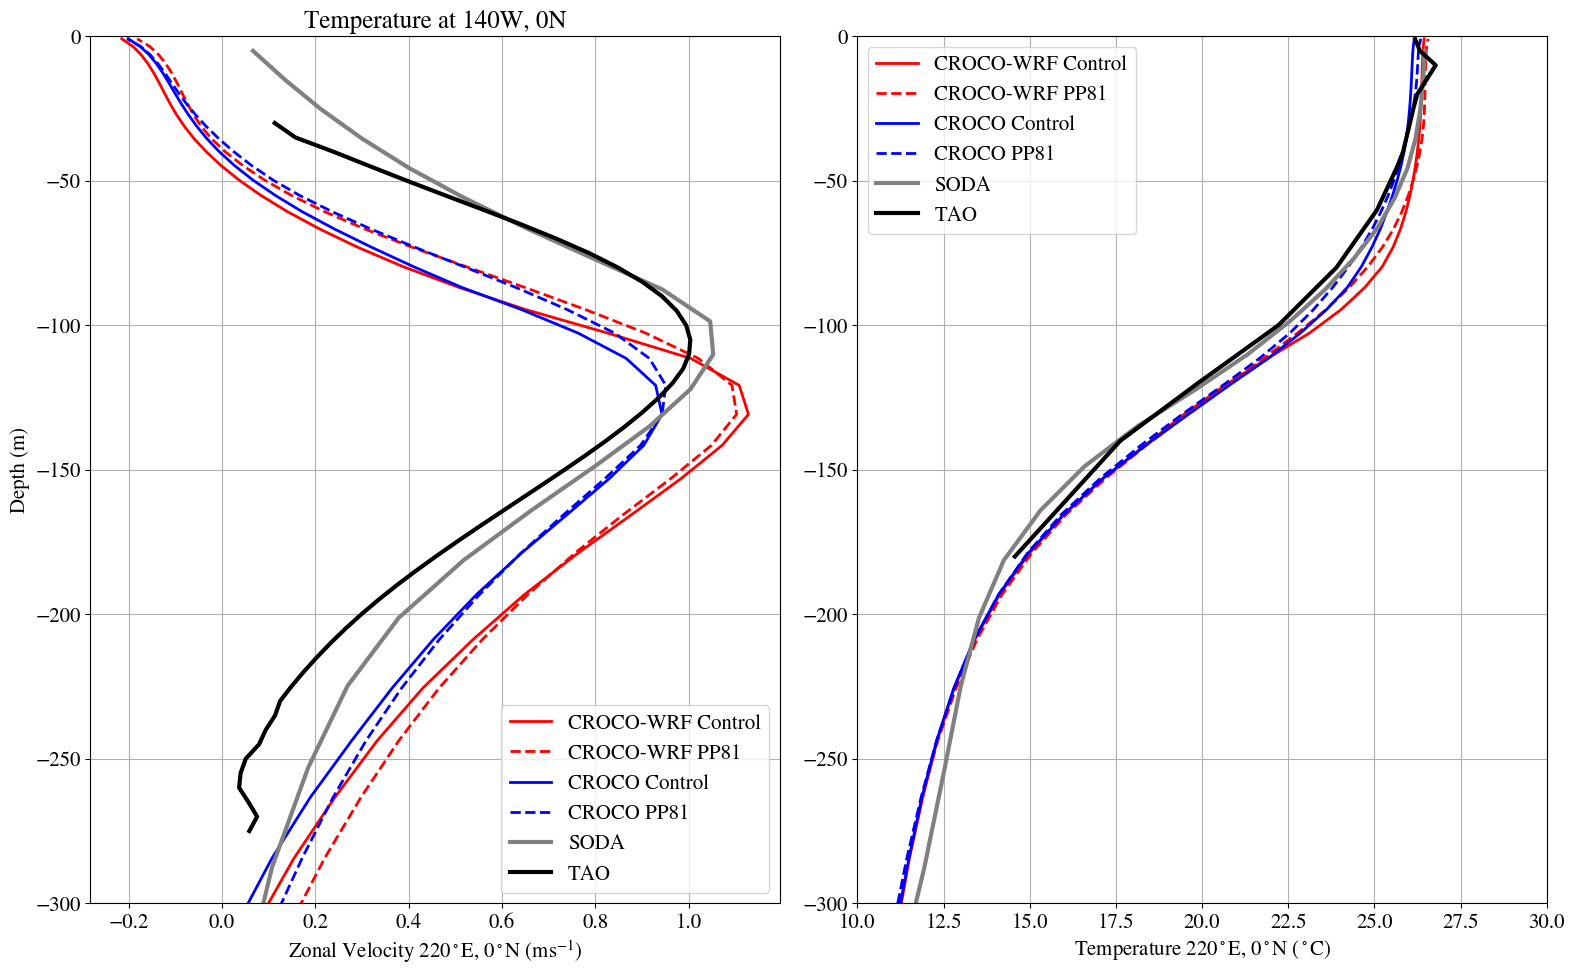

In [37]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(16,10), facecolor='w')
ax5 = axes[0]
ax6 = axes[1]

### Panel 6 and 7: Vertical structure (requires loading the variables below.
ax5.plot(UZ['CROCO-WRF Control'],Z,linewidth=2,label='CROCO-WRF Control',color='r')
ax5.plot(UZ['CROCO-WRF PP81'],Z,linewidth=2,label='CROCO-WRF PP81',color='r',linestyle='--')
ax5.plot(UZ['CROCO Control'],Z,linewidth=2,label='CROCO Control',color='b')
ax5.plot(UZ['CROCO PP81'],Z,linewidth=2,label='CROCO PP81',color='b',linestyle='--')
ax5.plot(SODA_UZ,SODA_Z,linewidth=3,label='SODA',color=[0.5,0.5,0.5])
ax5.plot(TAO_U_TAOm,-TAO_U.depth,linewidth=3,label='TAO',color='k')

ax6.plot(TZ['CROCO-WRF Control'],Z,linewidth=2,label='CROCO-WRF Control',color='r')
ax6.plot(TZ['CROCO-WRF PP81'],Z,linewidth=2,label='CROCO-WRF PP81',color='r',linestyle='--')
ax6.plot(TZ['CROCO Control'],Z,linewidth=2,label='CROCO Control',color='b')
ax6.plot(TZ['CROCO PP81'],Z,linewidth=2,label='CROCO PP81',color='b',linestyle='--')
ax6.plot(SODA_TZ,SODA_Z,linewidth=3,label='SODA',color=[0.5,0.5,0.5])
ax6.plot(TAO_T_TAOm,-TAO_T.depth,linewidth=3,label='TAO',color='k')

ax5.set_ylabel('Depth (m)')
ax5.legend()
ax5.set_xlabel('Zonal Velocity 220$^\circ$E, 0$^\circ$N (ms$^{-1}$)')
ax6.set_xlim([10.,30.])
ax6.legend()
ax6.set_xlabel('Temperature 220$^\circ$E, 0$^\circ$N ($^\circ$C)')

for ax in [ax5,ax6]:
    ax.set_ylim([-300.,0.])
    ax.grid()
ax5.set_title('Zonal Velocity at 140W, 0N')
ax5.set_title('Temperature at 140W, 0N')
plt.tight_layout()

plt.savefig('Mixing_Comparisons/PP81_CROCO_CROCO-WRF_UT_140W_0N.png',dpi=100)

## Longitude surface profiles:

In [15]:
LON = 220.
LON_OM2 = -140.

# Calculations
CROCO_SST = {}
CROCO_SSH = {}
CROCO_U = {}
for nam in expdict.keys():
    CROCO_SST[nam] = data[nam]['mon'].sel(x_rho=LON,method='nearest').temp.isel(s_rho=-1).mean('time').load()
    CROCO_SSH[nam] = data[nam]['mon'].sel(x_rho=LON,method='nearest').zeta.mean('time') - data[nam]['mon'].zeta.sel(x_rho=LON,method='nearest').mean('time').mean('y_rho')
    CROCO_SSH[nam].load()

    CROCO_U[nam] = data[nam]['mon'].u.sel(x_u=LON,method='nearest').isel(s_rho=-1).mean('time').load()

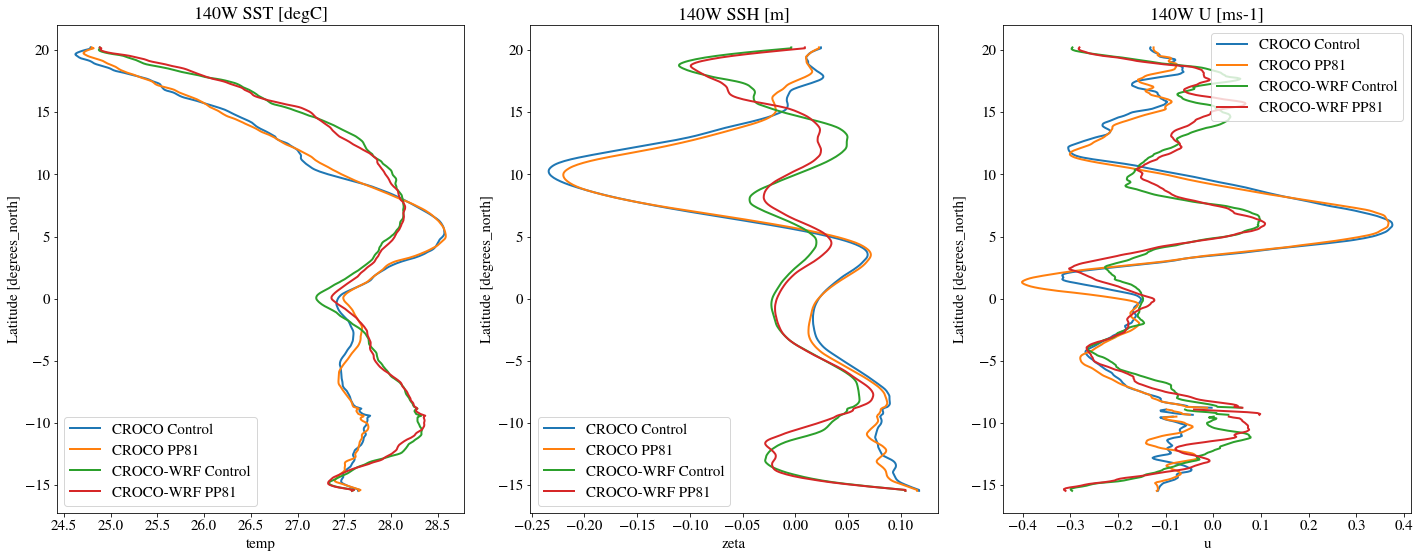

In [16]:
## Latitude line plots:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,8),facecolor='w')

for nam in expdict.keys():
    CROCO_SST[nam].plot(y='y_rho',ax=axes[0],label=nam)
    CROCO_SSH[nam].plot(y='y_rho',ax=axes[1],label=nam)
    CROCO_U[nam].plot(y='y_u',ax=axes[2],label=nam)

axes[0].set_title('140W SST [degC]')
axes[0].legend()
axes[1].set_title('140W SSH [m]')
axes[1].legend()
axes[2].set_title('140W U [ms-1]')
axes[2].legend()
plt.tight_layout()
plt.savefig('PP81_WRF_SST_SSH_U_LatProf_2015.png',dpi=100)

## Longitude-depth and latitude-depth profiles of temperature and zonal velocity:

In [17]:
# Region definitions:

depths = (0,300)    # Define depth range for all plots [m]

EqPlons = (175.,275.) # Define longitude range for longitude-depth plot [degrees]
EqPlat = 0.         # Define latitude for longitude-depth plot [degrees]

Ltlon = -140.       # Define longitude for latitude-depth plot [degrees]
ObsLtlon = 220.     # Define longitude for latitude-depth plot for Johnson observations. [degrees]
Ltlats = (-8,10)    # Define latitudes for latitude-depth plot [degrees]

In [18]:
u_140w = {}
temp_140w = {}
z_140w = {}
u_eq = {}
temp_eq = {}
z_eq = {}
for nam in expdict.keys():
    print(nam)
    # CROCO calculations:
    xind = abs(data[nam]['mon'].x_rho-220.).argmin().values
    yind = abs(data[nam]['mon'].y_rho).argmin().values

    # 140W depth-lat
    u_140w[nam] = data[nam]['mon'].u.isel(x_u=xind).mean('time').load()
    temp_140w[nam] = data[nam]['mon'].temp.isel(x_rho=xind).mean('time').load()
    z_140w[nam] = data[nam]['mon'].z_rho.isel(x_rho=xind).mean('time').load()

    # Equatorial depth-longitude:
    u_eq[nam] = data[nam]['mon'].u.isel(y_u=yind).mean('time').load()
    temp_eq[nam] = data[nam]['mon'].temp.isel(y_rho=yind).mean('time').load()
    z_eq[nam] = data[nam]['mon'].z_rho.isel(y_rho=yind).mean('time').load()

CROCO Control
CROCO PP81
CROCO-WRF Control
CROCO-WRF PP81


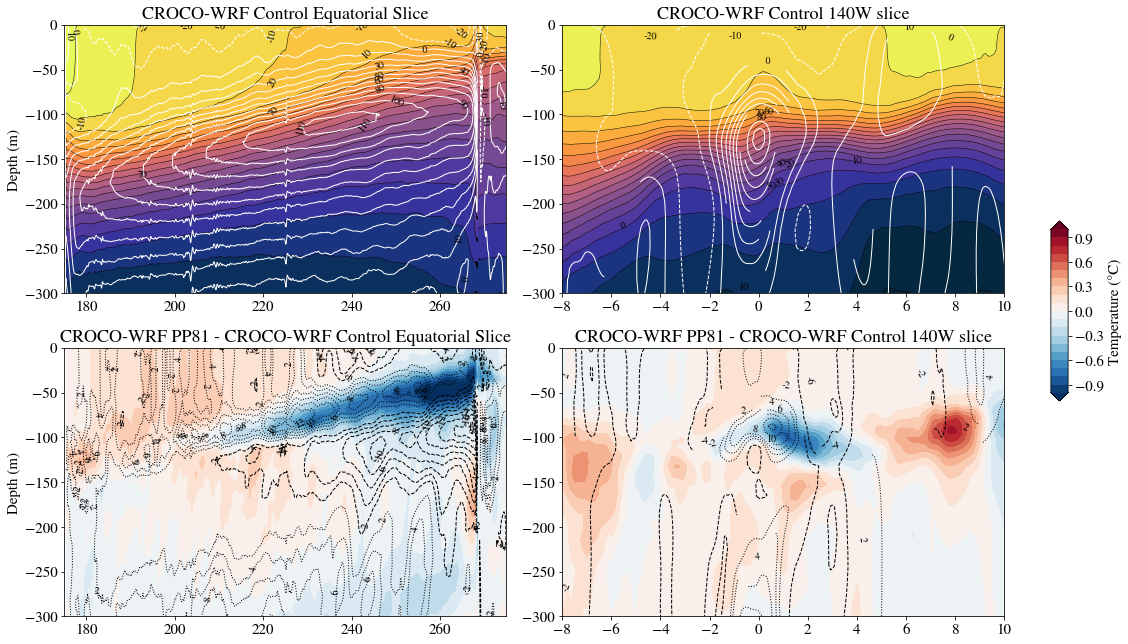

In [19]:
cont = 'CROCO-WRF Control'
exps = ['CROCO-WRF PP81']
# Define colobar limits and labels:
clevelsT = np.arange(10.,30.,1.)
clevelsU = np.arange(-50,130,10)

clevelsTp = np.arange(-1.,1.1,0.1)
clevelsUp = np.arange(-20.,0.,2.)
clevelsUm = np.arange(2.,22.,2.)

fig = plt.figure(figsize=(16,5+5*len(exps)),facecolor='w')

# Plot equatorial slice:
nam = cont
plt.subplot(1+len(exps),2,1)
xv, yv = np.meshgrid(temp_eq[nam].x_rho,z_eq[nam].isel(x_rho=0))
p1=plt.contourf(xv,z_eq[nam],temp_eq[nam],cmap=cm.cm.thermal, 
                               levels=clevelsT,
                               add_colorbar=False, extend='both')
plt.contour(xv,z_eq[nam],temp_eq[nam],levels=clevelsT,colors='k',linewidths=0.5)
xv, yv = np.meshgrid(u_eq[nam].x_u,z_eq[nam].isel(x_rho=0))
p2=plt.contour(xv,z_eq[nam].isel(x_rho=slice(0,-1)),100*u_eq[nam],colors='w',levels=clevelsU,linewidths=1)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([-300.,0.])
plt.xlim(EqPlons)
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title(cont + ' Equatorial Slice')

# Plot latitude-depth slice:
plt.subplot(1+len(exps),2,2)
xv, yv = np.meshgrid(temp_140w[nam].y_rho,z_140w[nam].isel(y_rho=0))
p3=plt.contourf(xv,z_140w[nam],temp_140w[nam],cmap=cm.cm.thermal, 
                               levels=clevelsT,
                               add_colorbar=False, extend='both')
plt.contour(xv,z_140w[nam],temp_140w[nam],levels=clevelsT,colors='k',linewidths=0.5)
xv, yv = np.meshgrid(u_140w[nam].y_u,z_140w[nam].isel(y_rho=0))
p4=plt.contour(xv,z_140w[nam],100*u_140w[nam],colors='w',levels=clevelsU,linewidths=1)
plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([-300.,0.])
plt.xlim(Ltlats)
plt.xlabel('')
plt.ylabel('')
plt.title(cont + ' 140W slice')

for i, nam in enumerate(exps):
    # Plot equatorial slice:
    plt.subplot(1+len(exps),2,2*(i+1)+1)
    xv, yv = np.meshgrid(temp_eq[nam].x_rho,z_eq[nam].isel(x_rho=0))
    p1=plt.contourf(xv,z_eq[nam],temp_eq[nam]-temp_eq[cont],cmap='RdBu_r', 
                                   levels=clevelsTp,
                                   add_colorbar=False, extend='both')
    xv, yv = np.meshgrid(u_eq[nam].x_u,z_eq[nam].isel(x_rho=0))
    p2=plt.contour(xv,z_eq[nam].isel(x_rho=slice(0,-1)),100*(u_eq[nam]-u_eq[cont]),colors='k',levels=clevelsUp,linewidths=1)
    plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
    p2=plt.contour(xv,z_eq[nam].isel(x_rho=slice(0,-1)),100*(u_eq[nam]-u_eq[cont]),colors='k',levels=clevelsUm,linestyles='dotted',linewidths=1)
    plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
    plt.ylim([-300.,0.])
    plt.xlim(EqPlons)
    plt.xlabel('')
    plt.ylabel('Depth (m)')
    plt.title(nam + ' - ' + cont + ' Equatorial Slice')

    # Plot latitude-depth slice:
    plt.subplot(1+len(exps),2,2*(i+1)+2)
    xv, yv = np.meshgrid(temp_140w[nam].y_rho,z_140w[nam].isel(y_rho=0))
    p3=plt.contourf(xv,z_140w[nam],temp_140w[nam]-temp_140w[cont],cmap='RdBu_r', 
                                   levels=clevelsTp,
                                   add_colorbar=False, extend='both')
    xv, yv = np.meshgrid(u_140w[nam].y_u,z_140w[nam].isel(y_rho=0))
    p4=plt.contour(xv,z_140w[nam],100*(u_140w[nam]-u_140w[cont]),colors='k',levels=clevelsUp,linewidths=1)
    plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
    p4=plt.contour(xv,z_140w[nam],100*(u_140w[nam]-u_140w[cont]),colors='k',levels=clevelsUm,linestyles='dotted',linewidths=1)
    plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
    plt.ylim([-300.,0.])
    plt.xlim(Ltlats)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(nam + ' - ' + cont + ' 140W slice')


# Add colorbar:
ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical', extend='both')
cb.ax.set_ylabel('Temperature (°C)')
fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])

plt.savefig('PP81_WRF_Equatorial_140W_Slices_2015.png',dpi=150)

## Vertical profiles at a given location (Annual Mean and TAO-matched times)

In [20]:
# Calculations:
LONsn = ['140W','110W']
stys = ['solid','dashed']
LONs = [220.,250.]
LAT = 0.
depths = (0.,300.)

CROCO_U = {}
CROCO_T = {}
CROCO_Z = {}
CROCO_K = {}
for i,LON in enumerate(LONs):
    CROCO_U[LONsn[i]] = {}
    CROCO_T[LONsn[i]] = {}
    CROCO_Z[LONsn[i]] = {}
    CROCO_K[LONsn[i]] = {}
    for nam in expdict.keys():
        CROCO_U[LONsn[i]][nam] = data[nam]['mon'].u.sel(x_u=LON,method='nearest').sel(y_u=LAT,method='nearest').mean('time').load()
        CROCO_T[LONsn[i]][nam] = data[nam]['mon'].temp.sel(x_rho=LON,method='nearest').sel(y_rho=LAT,method='nearest').mean('time').load()
        CROCO_Z[LONsn[i]][nam] = data[nam]['mon'].z_rho.sel(x_rho=LON,method='nearest').sel(y_rho=LAT,method='nearest').mean('time').load()
        CROCO_K[LONsn[i]][nam] = grid.interp(data[nam]['mon'].AKt.sel(x_w=LON,method='nearest').sel(y_w=LAT,method='nearest').mean('time').load(),axis='s')

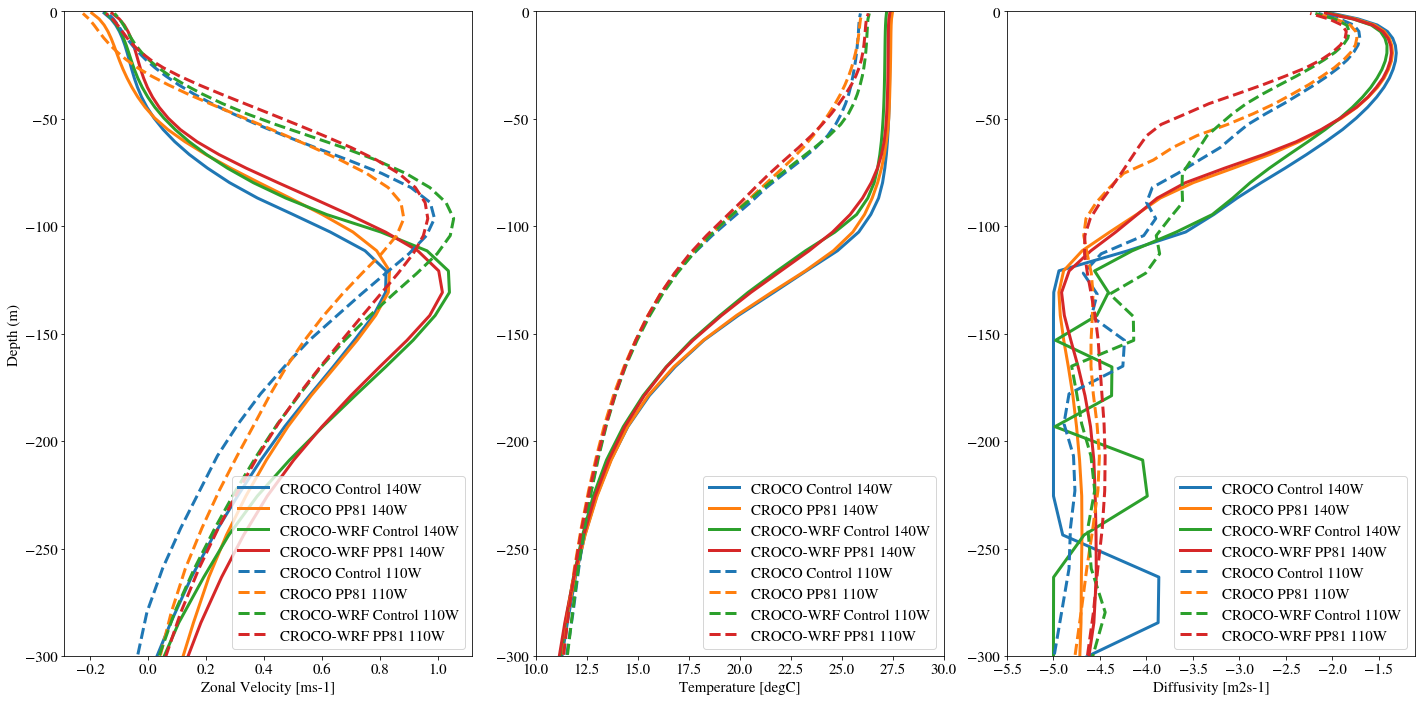

In [21]:
cols = {'CROCO Control':'C0','CROCO PP81':'C1','CROCO-WRF Control':'C2','CROCO-WRF PP81':'C3'}

plt.figure(figsize=(20,10),facecolor='w')

plt.subplot(1,3,1)
for i,LON in enumerate(LONs):
    for nam in expdict.keys():
        plt.plot(CROCO_U[LONsn[i]][nam],CROCO_Z[LONsn[i]][nam],linestyle=stys[i],label=nam + ' ' + LONsn[i],color=cols[nam],linewidth=3.)

plt.ylim([-300.,0.])
plt.legend()
plt.ylabel('Depth (m)')
plt.xlabel('Zonal Velocity [ms-1]')

plt.subplot(1,3,2)
for i,LON in enumerate(LONs):
    for nam in expdict.keys():
        plt.plot(CROCO_T[LONsn[i]][nam],CROCO_Z[LONsn[i]][nam],linestyle=stys[i],label=nam + ' ' + LONsn[i],color=cols[nam],linewidth=3.)

plt.ylim([-300.,0.])
plt.xlim([10.,30.])
plt.legend()
plt.xlabel('Temperature [degC]')

plt.subplot(1,3,3)
for i,LON in enumerate(LONs):
    for nam in expdict.keys():
        plt.plot(np.log10(CROCO_K[LONsn[i]][nam]),CROCO_Z[LONsn[i]][nam],linestyle=stys[i],label=nam + ' ' + LONsn[i],color=cols[nam],linewidth=3.)

plt.ylim([-300.,0.])
#plt.xlim([10.,30.])
plt.legend()
plt.xlabel('Diffusivity [m2s-1]')
plt.tight_layout()

plt.savefig('PP81_WRF_2015_VertProf_U_T_K.png',dpi=150)

## Some snapshot plotting from 3 day data:

In [22]:
#time = '2016-11-01'
time = '2015-12-04'
LAT = 0.

U = {}
V = {}
T = {}
K = {}
Z = {}
HBL = {}
for nam in expdict.keys():
    # CROCO calculations:
    yind = abs(data[nam]['mon'].y_rho-LAT).argmin().values

    # Equatorial depth-longitude:
    freq = '3day'
    #freq = 'mon'
    U[nam] = data[nam][freq].u.isel(y_u=yind).sel(time=time,method='nearest').load()
    V[nam] = data[nam][freq].v.isel(y_v=yind).sel(time=time,method='nearest').load()
    T[nam] = data[nam][freq].temp.isel(y_rho=yind).sel(time=time,method='nearest').load()
    Z[nam] = data[nam]['mon'].z_rho.isel(y_rho=yind).sel(time=time,method='nearest').load()
    K[nam] = grid.interp(data[nam][freq].AKt.isel(y_w=yind).sel(time=time,method='nearest').load(),'s')
    HBL[nam] = data[nam][freq].hbl.isel(y_rho=yind).sel(time=time,method='nearest').load()

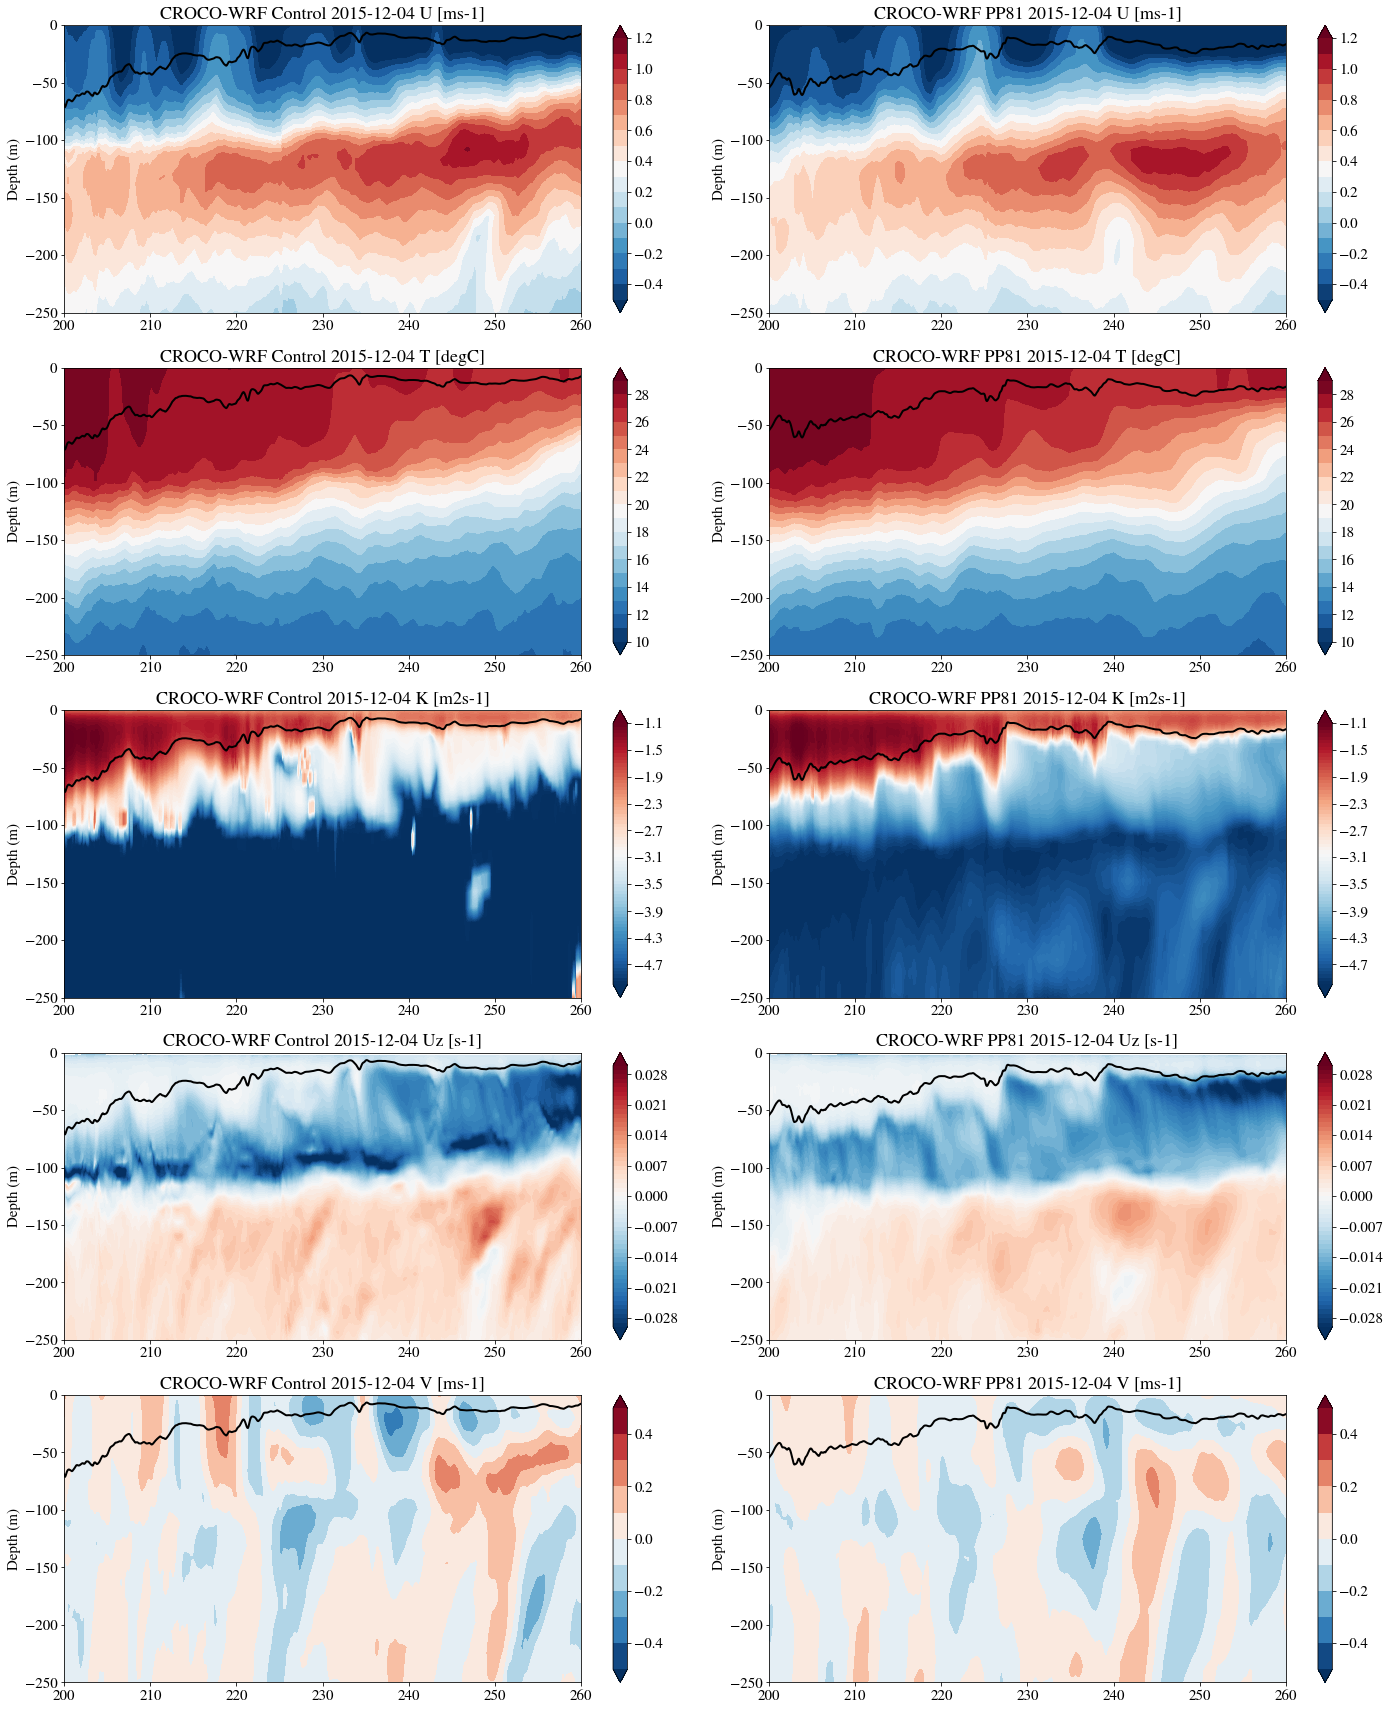

In [23]:
fig, axes = plt.subplots(nrows=5,ncols=2,figsize=(20,24),facecolor='w')

clevelsT = np.arange(10.,30.,1.)
clevelsU = np.arange(-0.5,1.3,0.1)
clevelsV = np.arange(-0.5,0.6,0.1)
clevelsUz = np.arange(-0.03,0.031,0.001)
clevelsK = np.arange(-5.,-1.05,0.05)
lons = [200.,260.]

keys = ['CROCO-WRF Control','CROCO-WRF PP81']
for i, nam in enumerate(keys):
    # U:
    xv, yv = np.meshgrid(U[nam].x_u,Z[nam].isel(x_rho=0))
    p1 = axes[0][i].contourf(xv,Z[nam].isel(x_rho=slice(0,-1)).fillna(0.).values,U[nam],cmap='RdBu_r', 
                               levels=clevelsU, extend='both')
    plt.colorbar(p1,ax=axes[0][i])
    axes[0][i].plot(HBL[nam].x_rho,-HBL[nam],color='k')
    axes[0][i].set_ylim([-250.,0.])
    axes[0][i].set_xlim(lons)
    axes[0][i].set_xlabel('')
    axes[0][i].set_ylabel('Depth (m)')
    axes[0][i].set_title(nam + ' ' + time + ' U [ms-1]')
    
    # T:
    xv, yv = np.meshgrid(T[nam].x_rho,Z[nam].isel(x_rho=0))
    p1 = axes[1][i].contourf(xv,Z[nam].fillna(0.).values,T[nam],cmap='RdBu_r', 
                               levels=clevelsT, extend='both')
    plt.colorbar(p1,ax=axes[1][i])
    axes[1][i].plot(HBL[nam].x_rho,-HBL[nam],color='k')
    axes[1][i].set_ylim([-250.,0.])
    axes[1][i].set_xlim(lons)
    axes[1][i].set_xlabel('')
    axes[1][i].set_ylabel('Depth (m)')
    axes[1][i].set_title(nam + ' ' + time + ' T [degC]')
    
    # K:
    xv, yv = np.meshgrid(K[nam].x_w,Z[nam].isel(x_rho=0))
    p1 = axes[2][i].contourf(xv,Z[nam].fillna(0.).values,np.log10(K[nam]),cmap='RdBu_r', 
                               levels=clevelsK,extend='both')
    plt.colorbar(p1,ax=axes[2][i])
    axes[2][i].plot(HBL[nam].x_rho,-HBL[nam],color='k')
    axes[2][i].set_ylim([-250.,0.])
    axes[2][i].set_xlim(lons)
    axes[2][i].set_xlabel('')
    axes[2][i].set_ylabel('Depth (m)')
    axes[2][i].set_title(nam + ' ' + time + ' K [m2s-1]')
    
    # Uz:
    xv, yv = np.meshgrid(U[nam].x_u,grid.interp(Z[nam].isel(x_rho=0),'s',boundary='extend'))
    p1 = axes[3][i].contourf(xv,grid.interp(Z[nam].isel(x_rho=slice(0,-1)),'s',boundary='extend').fillna(0.).values,grid.diff(U[nam],'s',boundary='extend')/grid.diff(Z[nam].isel(x_rho=slice(0,-1)),'s',boundary='extend').fillna(0.).values,cmap='RdBu_r', 
                               levels=clevelsUz, extend='both')
    plt.colorbar(p1,ax=axes[3][i])
    axes[3][i].plot(HBL[nam].x_rho,-HBL[nam],color='k')
    axes[3][i].set_ylim([-250.,0.])
    axes[3][i].set_xlim(lons)
    axes[3][i].set_xlabel('')
    axes[3][i].set_ylabel('Depth (m)')
    axes[3][i].set_title(nam + ' ' + time + ' Uz [s-1]')
    
    # V:
    xv, yv = np.meshgrid(V[nam].x_v,Z[nam].isel(x_rho=0))
    p1 = axes[4][i].contourf(xv,Z[nam].fillna(0.).values,V[nam],cmap='RdBu_r', 
                               levels=clevelsV, extend='both')
    plt.colorbar(p1,ax=axes[4][i])
    axes[4][i].plot(HBL[nam].x_rho,-HBL[nam],color='k')
    axes[4][i].set_ylim([-250.,0.])
    axes[4][i].set_xlim(lons)
    axes[4][i].set_xlabel('')
    axes[4][i].set_ylabel('Depth (m)')
    axes[4][i].set_title(nam + ' ' + time + ' V [ms-1]')
plt.tight_layout()
plt.savefig('PP81_WRF_' + time + '_Eqslice.png',dpi=150)